In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
from RS.core import *
from RS.model import *

In [ ]:
from fastai.vision.all import *

In [ ]:
df=pd.read_csv('./train.csv')

In [ ]:
db = DataBlock(blocks=(TransformBlock(type_tfms=partial(RsImage.create)),
                       TransformBlock(type_tfms=partial(RsMask.create)),
                      ),
               get_x=ColReader('path'),
               get_y=ColReader('path'),
               splitter=ColSplitter('valid'),
               item_tfms=[aug,aug2]
              )

# db.summary(source=df)

In [ ]:

dls = db.dataloaders(source=df,bs=1, num_workers=8)


In [ ]:
model=ResNestedUNet(num_classes=10,input_channels=4,deep_supervision=False)

In [ ]:
states=torch.load('./models/resunet.pth')

In [ ]:
model.load_state_dict(states)

<All keys matched successfully>

In [ ]:
model.cuda().eval()

In [ ]:
import tqdm

In [ ]:
def IOU( pred,label, num_classes=10):
    pred = F.softmax(pred, dim=1)              
    pred = torch.argmax(pred, dim=1).squeeze(1)
    present_iou_list = np.zeros(num_classes)
    pred = pred.view(-1)
    label = label.view(-1)
    # Note: Following for loop goes from 0 to (num_classes-1)
    # and ignore_index is num_classes, thus ignore_index is
    # not considered in computation of IoU.
    for sem_class in range(num_classes):
        if sem_class!=30:
            pred_inds = (pred == sem_class)
            target_inds = (label == sem_class)
            if target_inds.long().sum().item() == 0:
                iou_now = float('nan')
            else: 
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = float(intersection_now) / float(union_now)
                present_iou_list[sem_class]=iou_now
    return present_iou_list

In [ ]:
ioussmall=[]
iousbig=[]
iousnormal=[]
iouss=[]
IOUn=[]
IOUs=[]
IOUb=[]
Iouf=[]

for img,label in tqdm.tqdm(dls.valid):
    with torch.no_grad():
        result=model(img)
        resultsmall=model(F.avg_pool2d(img,2))
        resultbig=model(F.upsample_bilinear(img,scale_factor=2))
    resultsmall=F.upsample_nearest(resultsmall,scale_factor=2)
    resultbig=F.upsample_nearest(resultbig,scale_factor=0.5)
    temp=IOU(resultsmall,label)
    ioussmall.append(temp)
    IOUs.append(np.nanmean(temp[temp!=0]))
    temp=IOU(resultbig,label)
    iousbig.append(temp)
    IOUb.append(np.nanmean(temp[temp!=0]))
    temp=IOU(result,label)
    iousnormal.append(temp)
    IOUn.append(np.nanmean(temp[temp!=0]))
    final=torch.cat((result,resultsmall,result)).max(dim=0)[0].unsqueeze(0)    
    
    temp=IOU(final,label)
    iouss.append(temp)
    Iouf.append(np.nanmean(temp[temp!=0]))

100%|██████████| 1000/1000 [01:04<00:00, 15.50it/s]


In [ ]:
np.mean(IOUn),np.mean(IOUs),np.mean(IOUb),np.mean(Iouf)

(0.5653191461106647,
 0.49684722509666857,
 0.49731780533390835,
 0.5548164931745874)

In [ ]:
np.asarray(ioussmall).mean(axis=0)

array([3.68022865e-01, 8.24807005e-01, 1.23681789e-03, 6.08031373e-02,
       2.11516339e-03, 7.58265864e-02, 1.06529124e-02, 1.13778025e-02,
       1.22728056e-01, 2.83816128e-04])

In [ ]:
np.asarray(iousbig).mean(axis=0)

array([0.4495213 , 0.84564855, 0.00621638, 0.10307262, 0.00786099,
       0.1602063 , 0.01822766, 0.01834135, 0.18301341, 0.00772093])

In [ ]:
np.asarray(iousnormal).mean(axis=0)

array([0.52416253, 0.87215355, 0.02077488, 0.13245133, 0.00933888,
       0.23663429, 0.02253046, 0.02746339, 0.20179011, 0.01082341])

In [ ]:
import skimage.io as skio

In [ ]:
imgs=get_files('/home/staff/xin/Downloads/tianchi/test/')

In [ ]:
from mmseg.models import build_segmentor
from mmcv.utils import Config
import tqdm

In [ ]:
class HRNET(nn.Module):
    def __init__(self,cfgfile):
        super().__init__()
        cfg = Config.fromfile(cfgfile)
        temp=build_segmentor(cfg.model)
        self.backbone =temp.backbone
        self.decode_head = temp.decode_head
    def forward(self, x):
#         x=F.upsample_bilinear(x,scale_factor=2)
        x = self.backbone(x)
        x = self.decode_head(x)
        return x

In [ ]:

model=HRNET(cfgfile='./fcn_hr18.py')
apply_init(model)

In [ ]:
state=torch.load('./models/hrnetdisiou.pth')

In [ ]:
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
model=model.cuda().eval()

In [ ]:
def tta(temp):
    out=temp.unsqueeze(0).detach().clone()
    out=out.repeat(4,1,1,1)
    for i in range(3):
        newtemp=np.rot90(temp,axes=(1,2),k=i+1)
        out[i+1]=torch.from_numpy(newtemp.copy())
    return out
def ttaback(result):
    result=result.cpu()
    for i in range(3):
        newtemp=np.rot90(result[i+1],axes=(1,2),k=-1*(i+1))
        result[i+1]=torch.from_numpy(newtemp.copy())
    return result
    

In [ ]:
for img in tqdm.tqdm(imgs):
    temp=RsImage.create(img)
#     break
    temp=val_pipe(image=temp.numpy())['image']
    temp=tta(temp)
    with torch.no_grad():
        result=model(temp.cuda())
    result=F.softmax(result,dim=1)
    result=ttaback(result)
    result=result.max(dim=0)[0]
    result =F.upsample_bilinear(result.unsqueeze(0),scale_factor=4)  
    result=result.argmax(axis=1)
    result=result[0]+1
    result=result.numpy().astype('uint8')
    newname='/home/staff/xin/Downloads/tianchi/resultV0/'+img.name.replace('tif','png')
    skio.imsave(newname,result)

 76%|███████▋  | 2293/3000 [01:46<00:32, 21.49it/s]

In [ ]:
result.shape

torch.Size([1, 10, 256, 256])

In [ ]:
result.shape

torch.Size([10, 64, 256])

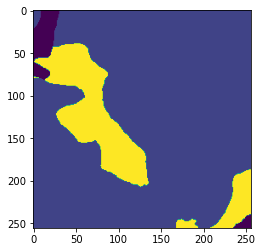

In [ ]:
plt.imshow(result)

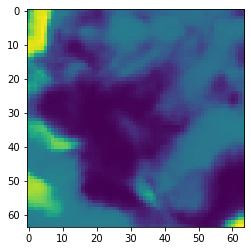

In [ ]:
plt.imshow(result[3][0])

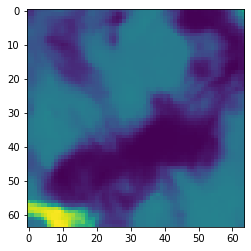

In [ ]:
plt.imshow(result[1][0].cpu())

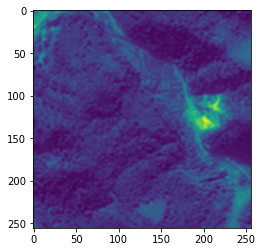

In [ ]:
plt.imshow(out[2][0])

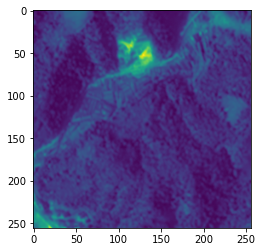

In [ ]:
plt.imshow(out[3][0])